In [2]:
import pandas as pd
import glob
import regex as re
import querygen as qg
# import pingouin as pg

import scipy.stats as stats

In [3]:
files = glob.glob("results_new_run/*.csv") + glob.glob("results/*.csv")
dfs = [pd.read_csv(f, index_col=0) for f in files]
files

['results/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results/eval_results_BTO_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv']

In [4]:
dfs

[    f1_score  precision  recall  f1_score_rel  precision_rel  recall_rel  \
 0   1.000000   1.000000     1.0      0.500000       0.500000       0.500   
 1   0.000000   0.000000     0.0      0.000000       0.000000       0.000   
 2   1.000000   1.000000     1.0      0.000000       0.000000       0.000   
 3   1.000000   1.000000     1.0      1.000000       1.000000       1.000   
 4   0.000000   0.000000     0.0      0.000000       0.000000       0.000   
 ..       ...        ...     ...           ...            ...         ...   
 70  0.000000   0.000000     0.0      0.000000       0.000000       0.000   
 71  0.777778   0.875000     0.7      0.875000       0.875000       0.875   
 72  0.666667   0.636364     0.7      0.250000       0.250000       0.250   
 73  0.000000   0.000000     0.0      0.000000       0.000000       0.000   
 74  0.900000   0.900000     0.9      0.666667       0.714286       0.625   
 
      ged  normed_ged                                           response  

In [5]:

def graph_from_erl(erl: qg.EnrichedEntitiesRelations):
    G = qg.nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity,
            link.target,
            weight=link.link.instance_count,
            label=link.relation,
        )
    return G

In [6]:
model_map = {
    "NousResearch Hermes 3 Llama 3.2 3B": "Hermes 3 3B",
    "NousResearch Hermes 3 Llama 3.1 8B": "Hermes 3 8B",
    "NousResearch Hermes 3 Llama 3.1 70B": "Hermes 3 70B",
    "bartowski Mistral Small Instruct": "Mistral Small 24B",
    "bartowski Qwen2.5 Coder 32B": "Qwen2.5 Coder 32B",
    "bartowski Qwen2.5 32B Instruct": "Qwen2.5 Instruct 32B",
}
chosen_models = [
    "Hermes 3 3B",
    "Hermes 3 8B",
    "Hermes 3 70B",
    "Qwen2.5 Coder 32B",
    "Qwen2.5 Instruct 32B",
]

In [7]:
dfs_model_clean = []
for f, df in zip(files, dfs):
    # data=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    # prompt_type=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    model = re.findall(r"eval_results_\w+_(.+)\.csv", f)[0]
    # df['prompt_type'] = prompt_type
    df["model"] = model.replace("_", " ").replace("-", " ")
    df["model"] = df["model"].apply(
        lambda x: next((v for k, v in model_map.items() if x.startswith(k)), x)
    )
    df = df[df["model"].isin(chosen_models)]
    dfs_model_clean.append(df)
df = pd.concat(dfs_model_clean)
df

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,response,model,cfg_name,zeroshot,stage,erl,generator,n_nodes,seed,erl_loaded
0,1.000000,1.000000,1.0,0.500000,0.50,0.5,1.0,0.800000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,False,raw,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel..."
1,0.000000,0.000000,0.0,0.000000,0.00,0.0,5.0,0.000000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,False,constrained,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel..."
2,1.000000,1.000000,1.0,0.000000,0.00,0.0,2.0,0.600000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,False,aligned,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel..."
3,1.000000,1.000000,1.0,1.000000,1.00,1.0,2.0,0.600000,A person has their state of origin in a countr...,Hermes 3 8B,DBpedia,False,raw,"{""relations"":[{""entity"":""person"",""relation"":""s...",human,3,15,"relations=[EnrichedRelation(entity='person', r..."
4,0.000000,0.000000,0.0,0.000000,0.00,0.0,6.0,-0.200000,A person has their state of origin in a countr...,Hermes 3 8B,DBpedia,False,constrained,"{""relations"":[{""entity"":""person"",""relation"":""s...",human,3,15,"relations=[EnrichedRelation(entity='person', r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.000000,0.000000,0.0,0.000000,0.00,0.0,12.0,-0.090909,"A person is born in a populated place, is the ...",Hermes 3 3B,DBpedia,False,constrained,"{""relations"":[{""entity"":""person"",""relation"":""b...",human,5,58,"relations=[EnrichedRelation(entity='person', r..."
62,0.727273,0.666667,0.8,0.500000,0.50,0.5,6.0,0.454545,"A person is born in a populated place, is the ...",Hermes 3 3B,DBpedia,False,aligned,"{""relations"":[{""entity"":""person"",""relation"":""b...",human,5,58,"relations=[EnrichedRelation(entity='person', r..."
63,0.600000,0.600000,0.6,0.400000,0.40,0.4,7.0,0.363636,"A place is the nearest city to a village, a di...",Hermes 3 3B,DBpedia,False,raw,"{""relations"":[{""entity"":""place"",""relation"":""ne...",human,5,59,"relations=[EnrichedRelation(entity='place', re..."
64,0.000000,0.000000,0.0,0.000000,0.00,0.0,10.0,-0.111111,"A place is the nearest city to a village, a di...",Hermes 3 3B,DBpedia,False,constrained,"{""relations"":[{""entity"":""place"",""relation"":""ne...",human,5,59,"relations=[EnrichedRelation(entity='place', re..."


In [8]:
df['n_nodes']= df['n_nodes'].astype(int)

In [9]:
df["model"].unique()

array(['Hermes 3 8B', 'Hermes 3 3B'], dtype=object)

In [10]:
df["prompt_type"] = df["zeroshot"].apply(lambda x: "zero shot" if x else "one shot")
df.drop(columns=["zeroshot"], inplace=True)
df

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,response,model,cfg_name,stage,erl,generator,n_nodes,seed,erl_loaded,prompt_type
0,1.000000,1.000000,1.0,0.500000,0.50,0.5,1.0,0.800000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,raw,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel...",one shot
1,0.000000,0.000000,0.0,0.000000,0.00,0.0,5.0,0.000000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,constrained,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel...",one shot
2,1.000000,1.000000,1.0,0.000000,0.00,0.0,2.0,0.600000,A work has a publisher who is a record labler ...,Hermes 3 8B,DBpedia,aligned,"{""relations"":[{""entity"":""work"",""relation"":""pub...",human,3,13,"relations=[EnrichedRelation(entity='work', rel...",one shot
3,1.000000,1.000000,1.0,1.000000,1.00,1.0,2.0,0.600000,A person has their state of origin in a countr...,Hermes 3 8B,DBpedia,raw,"{""relations"":[{""entity"":""person"",""relation"":""s...",human,3,15,"relations=[EnrichedRelation(entity='person', r...",one shot
4,0.000000,0.000000,0.0,0.000000,0.00,0.0,6.0,-0.200000,A person has their state of origin in a countr...,Hermes 3 8B,DBpedia,constrained,"{""relations"":[{""entity"":""person"",""relation"":""s...",human,3,15,"relations=[EnrichedRelation(entity='person', r...",one shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.000000,0.000000,0.0,0.000000,0.00,0.0,12.0,-0.090909,"A person is born in a populated place, is the ...",Hermes 3 3B,DBpedia,constrained,"{""relations"":[{""entity"":""person"",""relation"":""b...",human,5,58,"relations=[EnrichedRelation(entity='person', r...",one shot
62,0.727273,0.666667,0.8,0.500000,0.50,0.5,6.0,0.454545,"A person is born in a populated place, is the ...",Hermes 3 3B,DBpedia,aligned,"{""relations"":[{""entity"":""person"",""relation"":""b...",human,5,58,"relations=[EnrichedRelation(entity='person', r...",one shot
63,0.600000,0.600000,0.6,0.400000,0.40,0.4,7.0,0.363636,"A place is the nearest city to a village, a di...",Hermes 3 3B,DBpedia,raw,"{""relations"":[{""entity"":""place"",""relation"":""ne...",human,5,59,"relations=[EnrichedRelation(entity='place', re...",one shot
64,0.000000,0.000000,0.0,0.000000,0.00,0.0,10.0,-0.111111,"A place is the nearest city to a village, a di...",Hermes 3 3B,DBpedia,constrained,"{""relations"":[{""entity"":""place"",""relation"":""ne...",human,5,59,"relations=[EnrichedRelation(entity='place', re...",one shot


In [11]:
df_clean = df.dropna()
df_clean.describe()

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,n_nodes,seed
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.352149,0.367356,0.346189,0.340550,0.346861,0.340584,5.165289,0.276058,2.942149,41.694215
std,0.406274,0.422618,0.405131,0.440029,0.446980,0.442497,8.988649,0.360539,1.609524,36.001575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.333333,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,15.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.142857,2.000000,38.000000
75%,0.727273,0.788889,0.666667,1.000000,1.000000,1.000000,5.000000,0.552778,3.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.000000,1.000000,10.000000,231.000000


In [12]:
df["erl_loaded"] = df["erl"].apply(qg.EnrichedEntitiesRelations.model_validate_json)
# df["response_loaded"] = df["response"].apply(lambda x: qg.EnrichedEntitiesRelations.model_validate_json(x) if isinstance(x, str) else None)
df["erl_graph"] = df["erl_loaded"].apply(graph_from_erl)
# df["response_graph"] = df["response"].apply(lambda x: graph_from_erl if x is not None else None)

In [13]:
# df["normed_ged"] = 1 - df["ged"] / df["erl_graph"].apply(
#     lambda x: (len(x.nodes) + len(x.nodes))
# )

In [14]:
df_clean["generator"].unique(), df_clean["model"].unique()

(array(['human', 'llama', 'templated'], dtype=object),
 array(['Hermes 3 8B', 'Hermes 3 3B'], dtype=object))

In [15]:
means = df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].mean()
stds= df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].std()
counts = df_clean.groupby(
    ["n_nodes", "stage", "prompt_type", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].count()
means

f1_score  \
n_nodes prompt_type stage       model       generator cfg_name             
2       one shot    aligned     Hermes 3 3B llama     BTO       0.368254   
                                            templated BTO       0.528125   
                    constrained Hermes 3 3B llama     BTO       0.000000   
                                            templated BTO       0.000000   
                    raw         Hermes 3 3B llama     BTO       0.209524   
                                            templated BTO       0.820833   
3       one shot    aligned     Hermes 3 3B human     DBpedia   0.640693   
                                Hermes 3 8B human     DBpedia   0.443333   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.632035   
                                Hermes 3 8B human     DBpedia   0.540000   
5       one shot    aligned     Hermes 3 3B human     DBpedia   0.699331   
                                Hermes 3 8B human     DBpedia   0.733333   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.738659   
                                Hermes 3 8B human     DBpedia   0.643939   
10      one shot    aligned     Hermes 3 8B human     DBpedia   0.804873   
                    constrained Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 8B human     DBpedia   0.601170   

                                                                normed_ged  
n_nodes prompt_type stage       model       generator cfg_name              
2       one shot    aligned     Hermes 3 3B llama     BTO         0.446145  
                                            templated BTO         0.627083  
                    constrained Hermes 3 3B llama     BTO         0.000000  
                                            templated BTO         0.000000  
                    raw         Hermes 3 3B llama     BTO         0.112698  
                                            templated BTO         0.722917  
3       one shot    aligned     Hermes 3 3B human     DBpedia     0.578355  
                                Hermes 3 8B human     DBpedia     0.444762  
                    constrained Hermes 3 3B human     DBpedia    -0.018182  
                                Hermes 3 8B human     DBpedia    -0.040000  
                    raw         Hermes 3 3B human     DBpedia     0.419913  
                                Hermes 3 8B human     DBpedia     0.410000  
5       one shot    aligned     Hermes 3 3B human     DBpedia     0.439853  
                                Hermes 3 8B human     DBpedia     0.567971  
                    constrained Hermes 3 3B human     DBpedia    -0.133460  
                                Hermes 3 8B human     DBpedia    -0.163131  
                    raw         Hermes 3 3B human     DBpedia     0.248499  
                                Hermes 3 8B human     DBpedia     0.175337  
10      one shot    aligned     Hermes 3 8B human     DBpedia     0.469883  
                    constrained Hermes 3 8B human     DBpedia    -0.166834  
                    raw         Hermes 3 8B human     DBpedia     0.211362

In [16]:
stds

f1_score  \
n_nodes prompt_type stage       model       generator cfg_name             
2       one shot    aligned     Hermes 3 3B llama     BTO       0.394745   
                                            templated BTO       0.457366   
                    constrained Hermes 3 3B llama     BTO       0.000000   
                                            templated BTO       0.000000   
                    raw         Hermes 3 3B llama     BTO       0.370548   
                                            templated BTO       0.293141   
3       one shot    aligned     Hermes 3 3B human     DBpedia   0.358179   
                                Hermes 3 8B human     DBpedia   0.354878   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.250497   
                                Hermes 3 8B human     DBpedia   0.379994   
5       one shot    aligned     Hermes 3 3B human     DBpedia   0.135692   
                                Hermes 3 8B human     DBpedia   0.193265   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.149567   
                                Hermes 3 8B human     DBpedia   0.253185   
10      one shot    aligned     Hermes 3 8B human     DBpedia   0.084887   
                    constrained Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 8B human     DBpedia   0.177716   

                                                                normed_ged  
n_nodes prompt_type stage       model       generator cfg_name              
2       one shot    aligned     Hermes 3 3B llama     BTO         0.317139  
                                            templated BTO         0.384226  
                    constrained Hermes 3 3B llama     BTO         0.000000  
                                            templated BTO         0.000000  
                    raw         Hermes 3 3B llama     BTO         0.214129  
                                            templated BTO         0.289411  
3       one shot    aligned     Hermes 3 3B human     DBpedia     0.365424  
                                Hermes 3 8B human     DBpedia     0.316954  
                    constrained Hermes 3 3B human     DBpedia     0.060302  
                                Hermes 3 8B human     DBpedia     0.084327  
                    raw         Hermes 3 3B human     DBpedia     0.255567  
                                Hermes 3 8B human     DBpedia     0.204909  
5       one shot    aligned     Hermes 3 3B human     DBpedia     0.200569  
                                Hermes 3 8B human     DBpedia     0.235080  
                    constrained Hermes 3 3B human     DBpedia     0.120854  
                                Hermes 3 8B human     DBpedia     0.146193  
                    raw         Hermes 3 3B human     DBpedia     0.170987  
                                Hermes 3 8B human     DBpedia     0.206748  
10      one shot    aligned     Hermes 3 8B human     DBpedia     0.118847  
                    constrained Hermes 3 8B human     DBpedia     0.115434  
                    raw         Hermes 3 8B human     DBpedia     0.105898

In [17]:
counts

f1_score  \
n_nodes stage       prompt_type model       generator cfg_name             
2       aligned     one shot    Hermes 3 3B llama     BTO             42   
                                            templated BTO             32   
        constrained one shot    Hermes 3 3B llama     BTO             42   
                                            templated BTO             32   
        raw         one shot    Hermes 3 3B llama     BTO             42   
                                            templated BTO             32   
3       aligned     one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         10   
        constrained one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         10   
        raw         one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         10   
5       aligned     one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         12   
        constrained one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         12   
        raw         one shot    Hermes 3 3B human     DBpedia         11   
                                Hermes 3 8B human     DBpedia         12   
10      aligned     one shot    Hermes 3 8B human     DBpedia          3   
        constrained one shot    Hermes 3 8B human     DBpedia          3   
        raw         one shot    Hermes 3 8B human     DBpedia          3   

                                                                normed_ged  
n_nodes stage       prompt_type model       generator cfg_name              
2       aligned     one shot    Hermes 3 3B llama     BTO               42  
                                            templated BTO               32  
        constrained one shot    Hermes 3 3B llama     BTO               42  
                                            templated BTO               32  
        raw         one shot    Hermes 3 3B llama     BTO               42  
                                            templated BTO               32  
3       aligned     one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           10  
        constrained one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           10  
        raw         one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           10  
5       aligned     one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           12  
        constrained one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           12  
        raw         one shot    Hermes 3 3B human     DBpedia           11  
                                Hermes 3 8B human     DBpedia           12  
10      aligned     one shot    Hermes 3 8B human     DBpedia            3  
        constrained one shot    Hermes 3 8B human     DBpedia            3  
        raw         one shot    Hermes 3 8B human     DBpedia            3

In [18]:
column_map = {
    "f1_score": "$F_{1,node}$",
    "f1_score_rel": "$F_{1,rel.}$ ",
    "normed_ged": "$GED_{s}$",
    "stage": "Stage",
    "prompt_type": "Prompt Type",
    "model": "Version \\& Size",
    "n_nodes": "$k$",
    "generator": "Query Origin",
}

## Compare Query Origins on DBpedia with 8B model

In [20]:
query_gen_compare = df_clean[
    df_clean["model"].str.contains("3B")
    & df_clean["cfg_name"].str.contains("DBpedia")
    & df_clean["prompt_type"].str.contains("one shot")
    & ~df_clean["stage"].str.contains("constrained")
    & (df_clean["n_nodes"] < 6)
    & (df_clean["n_nodes"] > 2)
]
grouped_query_gen_compare = query_gen_compare.groupby(
    ["n_nodes", "generator", "stage"]
)[["f1_score", "normed_ged"]]
grouped_query_gen_compare_mean = grouped_query_gen_compare.mean()
grouped_query_gen_compare_std = grouped_query_gen_compare.std()
grouped_query_gen_compare_percentiles = grouped_query_gen_compare.quantile(
    [0.25, 0.5, 0.75]
)
grouped_query_gen_compare_mean = grouped_query_gen_compare_mean.rename(
    columns=column_map
).rename_axis(
    [column_map["n_nodes"], column_map["generator"], column_map["stage"]], axis=0
)
grouped_query_gen_compare_mean = grouped_query_gen_compare_mean.rename(
    columns={k: f"Mean {k}" for k in grouped_query_gen_compare_mean.columns}
)

# grouped_query_gen_compare_mean["TOST"] = ""
for n_nodes in query_gen_compare["n_nodes"].unique():
    for origin in ["llama", "templated"]:
        
        a = query_gen_compare[
            (query_gen_compare["generator"] == origin)
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"].to_numpy()
        b = query_gen_compare[
            (query_gen_compare["generator"] == "human")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"].to_numpy()
        
        # Bayesian t-test (Welch's version)

        bound = 0.2
        # Unpaired two-sample t-test
        _, p_greater = stats.ttest_ind(a + bound, b, alternative="greater")
        _, p_less = stats.ttest_ind(a - bound, b, alternative="less")
        # Choose the maximum p-value
        pval = max(p_less, p_greater)
        test = stats.ttest_ind(a, b, equal_var=False)
        # result = pg.bayesfactor_ttest(t=test.statistic, nx=a.shape[0], ny=a.shape[0], alternative="two-sided")
        # # print(f"TOST: n_nodes = {n_nodes}, origin = {origin}, p = {pval:.3f}")
        # print("--- n_nodes =", n_nodes, "and origin =", origin)
        # print(f"TOST: p = {pval:5.3f} (\delta = {bound})")
        # print(f"t-test (means): {test.statistic:.3f}, p-value: {test.pvalue:.3f}")
        # print(f"Bayes Factor: {1/result:.3f} (H1/H0)")
        # print(f"t-statistic: {test.statistic:.3f}, p-value: {test.pvalue:.3f}")
        # grouped_query_gen_compare_mean.loc[
        #     (n_nodes, origin, "aligned"), "TOST"
        # ] = pval
with open("tables/compare_gen_query.tex", "w") as f:
    f.write(
        grouped_query_gen_compare_mean.to_latex(
            float_format="%.2f",
            caption="Comparison of query generation methods for LLama 3.2 3B on DBpedia with one shot prompts.",
            label="tab:compare_gen_query",
        )
    )
grouped_query_gen_compare_mean

/home/bkantz/cgv/hereditary/onset/backend/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


Mean $F_{1,node}$  Mean $GED_{s}$
$k$ Query Origin Stage                                     
3   human        aligned           0.640693        0.578355
                 raw               0.632035        0.419913
5   human        aligned           0.699331        0.439853
                 raw               0.738659        0.248499

In [21]:
grouped_query_gen_compare_std

f1_score  normed_ged
n_nodes generator stage                        
3       human     aligned  0.358179    0.365424
                  raw      0.250497    0.255567
5       human     aligned  0.135692    0.200569
                  raw      0.149567    0.170987

In [22]:
for n_nodes in query_gen_compare["n_nodes"].unique():
    print("Two-sample t-test for n_nodes =", n_nodes)
    test = stats.ttest_ind(
        query_gen_compare[
            (query_gen_compare["generator"] == "templated")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"],
        query_gen_compare[
            (query_gen_compare["generator"] == "llama")
            & (query_gen_compare["n_nodes"] == n_nodes)
            & (query_gen_compare["stage"] == "aligned")
        ]["f1_score"],
        equal_var=False,
    )
    print(f"t-statistic: {test.statistic:.3f}, p-value: {test.pvalue:.3f}")

Two-sample t-test for n_nodes = 3
t-statistic: nan, p-value: nan
Two-sample t-test for n_nodes = 5
t-statistic: nan, p-value: nan


/home/bkantz/cgv/hereditary/onset/backend/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [23]:
grouped_query_gen_compare_mean

Mean $F_{1,node}$  Mean $GED_{s}$
$k$ Query Origin Stage                                     
3   human        aligned           0.640693        0.578355
                 raw               0.632035        0.419913
5   human        aligned           0.699331        0.439853
                 raw               0.738659        0.248499

In [24]:
grouped_query_gen_compare_percentiles

f1_score  normed_ged
n_nodes generator stage                             
3       human     aligned 0.25  0.533333    0.366667
                          0.50  0.800000    0.800000
                          0.75  0.857143    0.800000
                  raw     0.25  0.450000    0.242857
                          0.50  0.666667    0.400000
                          0.75  0.800000    0.600000
5       human     aligned 0.25  0.600000    0.277778
                          0.50  0.727273    0.444444
                          0.75  0.750000    0.555556
                  raw     0.25  0.600000    0.111111
                          0.50  0.727273    0.181818
                          0.75  0.844444    0.404040

## Compare models across Datasets

In [25]:
datasets = [
    "DBpedia",
    "UniProt",
    "BTO",
    "Yago",
    # "DNB",
]
quantiles = [0.25, 0.5, 0.75]
grouped_dfs: dict[str, pd.DataFrame] = {}
grouped_dfs_raw: dict[str, pd.DataFrame] = {}
for dataset in datasets:
    model_compare = df_clean[df_clean["cfg_name"].str.strip() == dataset]
    model_compare = model_compare[~model_compare["stage"].str.contains("constrained")]
    model_compare_selected=model_compare.groupby(
        [
            "n_nodes",
            "stage",
            "prompt_type",
            "model",
            # "generator",
        ]
    )[
        [
            "f1_score",
            "normed_ged",
            "f1_score_rel",
        ]
    ]
    grouped_model_compare = model_compare_selected.quantile(quantiles).rename_axis(
            [
                "n_nodes",
                "stage",
                "prompt_type",
                "model",
                "percentile",
            ]
        )
    grouped_model_compare_mean = model_compare_selected.mean()
    # append mean to the compare DataFrame with percentile as 'mean'
    grouped_model_compare_mean['percentile'] = 'mean'
    grouped_model_compare_mean.set_index(
        "percentile",
        append=True,
        inplace=True,
    )
    grouped_model_compare = pd.concat(
        [grouped_model_compare, grouped_model_compare_mean],
        axis=0,
    )
    
    grouped_dfs_raw[dataset] = (
        grouped_model_compare
        .reset_index()
        .copy()
    )
    grouped_model_compare = grouped_model_compare.rename(
        columns=column_map
    ).rename_axis(
        [
            column_map["n_nodes"],
            column_map["stage"],
            column_map["prompt_type"],
            column_map["model"],
            "Percentile",
            # column_map["generator"],
        ],
        axis=0,
    )
    grouped_dfs[dataset] = grouped_model_compare
    with open(f"tables/compare_model_{dataset}.tex", "w") as f:
        f.write(
            grouped_model_compare.to_latex(
                float_format="%.2f",
                caption=f"Comparison of models for {dataset}",
                label=f"tab:compare_model_{dataset}",
                # sparsify=False
            )
        )
dataset_keys = list(grouped_dfs.keys())
merged_grouped: pd.DataFrame = grouped_dfs[dataset_keys[0]].copy()
merged_grouped.rename(
    columns={
        "$F_{1,node}$": f"$F_{{1,node}}$_{dataset_keys[0]}",
        "$F_{1,rel.}$": f"$F_{{1,rel.}}$_{dataset_keys[0]}",
        "$GED_{s}$": f"$GED_{{s}}$_{dataset_keys[0]}",
    },
    inplace=True,
)
for dataset, grouped_df in list(grouped_dfs.items())[1:]:
    print(f"Merging {dataset} into the grouped DataFrame")
    merged_grouped = pd.merge(
        merged_grouped,
        grouped_dfs[dataset].rename(
            columns={
                column_map["f1_score"]: f"{column_map['f1_score']}_{dataset}",
                column_map["f1_score_rel"]: f"{column_map['f1_score_rel']}_{dataset}",
                column_map["normed_ged"]: f"{column_map['normed_ged']}_{dataset}",
            }
        ),
        on=[
            "$k$",
            "Stage",
            "Prompt Type",
            "Version \\& Size",
            "Percentile",
        ],
        # suffixes=(None, f"_{dataset}"),
    )
rename_map = (
    {
        f"{column_map['f1_score']}_{dataset}": f"{dataset} {column_map['f1_score']}"
        for dataset in datasets
    }
    | {
        f"{column_map['f1_score_rel']}_{dataset}": f"{dataset} {column_map['f1_score_rel']}"
        for dataset in datasets
    }
    | {
        f"{column_map['normed_ged']}_{dataset}": f"{dataset} {column_map['normed_ged']}"
        for dataset in datasets
    }
)
merged_grouped.rename(
    columns=rename_map,
    inplace=True,
)
with open("tables/compare_model_merged.tex", "w") as f:
    f.write(
        merged_grouped.to_latex(
            float_format="%.2f",
            caption="Comparison of models for DBpedia and UniProt",
            label="tab:compare_model_merged",
        )
    )

Merging UniProt into the grouped DataFrame
Merging BTO into the grouped DataFrame
Merging Yago into the grouped DataFrame


In [26]:
grouped_model_compare

,,,,,"$F_{1,node}$",$GED_{s}$,"$F_{1,rel.}$"
$k$,Stage,Prompt Type,Version \& Size,Percentile,,,


In [27]:
merged_grouped

,,,,,"DBpedia $F_{1,node}$",DBpedia $GED_{s}$,"$F_{1,rel.}$","UniProt $F_{1,node}$",UniProt $GED_{s}$,"UniProt $F_{1,rel.}$","BTO $F_{1,node}$",BTO $GED_{s}$,"BTO $F_{1,rel.}$","Yago $F_{1,node}$",Yago $GED_{s}$,"Yago $F_{1,rel.}$"
$k$,Stage,Prompt Type,Version \& Size,Percentile,,,,,,,,,,,,


In [28]:
grouped_dfs_raw

{'DBpedia':     n_nodes    stage prompt_type        model percentile  f1_score  \
 0         3  aligned    one shot  Hermes 3 3B       0.25  0.533333   
 1         3  aligned    one shot  Hermes 3 3B        0.5  0.800000   
 2         3  aligned    one shot  Hermes 3 3B       0.75  0.857143   
 3         3  aligned    one shot  Hermes 3 8B       0.25  0.100000   
 4         3  aligned    one shot  Hermes 3 8B        0.5  0.450000   
 5         3  aligned    one shot  Hermes 3 8B       0.75  0.666667   
 6         3      raw    one shot  Hermes 3 3B       0.25  0.450000   
 7         3      raw    one shot  Hermes 3 3B        0.5  0.666667   
 8         3      raw    one shot  Hermes 3 3B       0.75  0.800000   
 9         3      raw    one shot  Hermes 3 8B       0.25  0.350000   
 10        3      raw    one shot  Hermes 3 8B        0.5  0.500000   
 11        3      raw    one shot  Hermes 3 8B       0.75  0.916667   
 12        5  aligned    one shot  Hermes 3 3B       0.25  0.60000

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble="""\\usepackage{amsmath}""")
plt.style.use("fivethirtyeight")
# set background color to white of the figure and axes
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)


# https://github.com/nschloe/tikzplotlib/issues/567
# from matplotlib.lines import Line2D
# from matplotlib.legend import Legend

# Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
# Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
# Legend._ncol = property(lambda self: self._ncols)

import seaborn as sns

palette = sns.color_palette('pastel').as_hex()
def adjust_lightness(color, amount=1.1):
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], np.maximum(0, np.minimum(1, amount * c[1])), c[2])

plt.rcParams.update({'errorbar.capsize': 2})

In [31]:
grouped_dfs["UniProt"].index.names

FrozenList(['$k$', 'Stage', 'Prompt Type', 'Version \& Size', 'Percentile'])

In [32]:
from matplotlib.lines import Line2D
# Filter out filled markers and marker settings that do nothing.
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
unfilled_markers

[',',
 '1',
 '2',
 '3',
 '4',
 '+',
 'x',
 '|',
 '_',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11]

Plotting DBpedia - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - f1_score - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - f1_score - raw - Hermes 3 8B
x dashed #ffb482


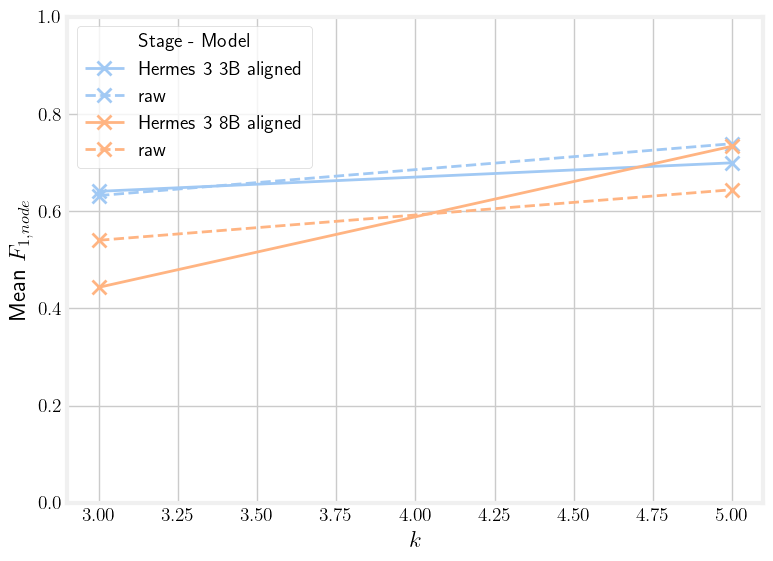

Plotting DBpedia - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - f1_score_rel - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - f1_score_rel - raw - Hermes 3 8B
x dashed #ffb482


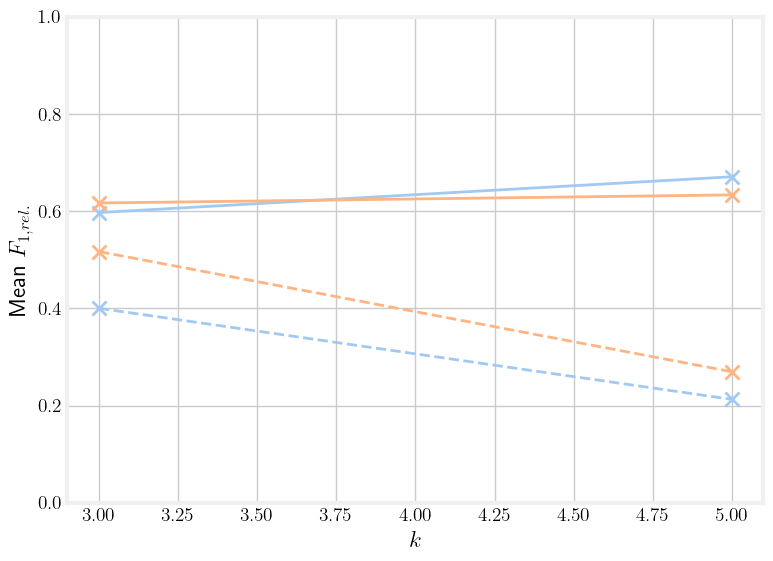

Plotting DBpedia - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting DBpedia - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4
Plotting DBpedia - normed_ged - aligned - Hermes 3 8B
x solid #ffb482
Plotting DBpedia - normed_ged - raw - Hermes 3 8B
x dashed #ffb482


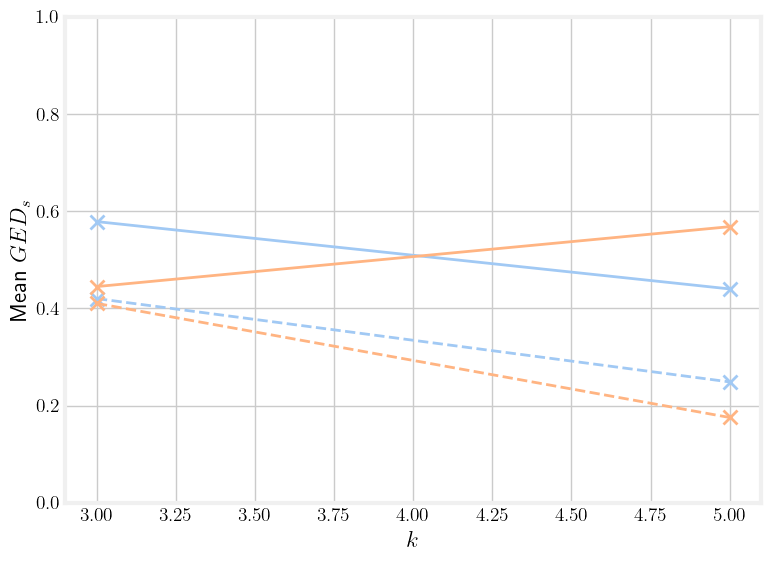

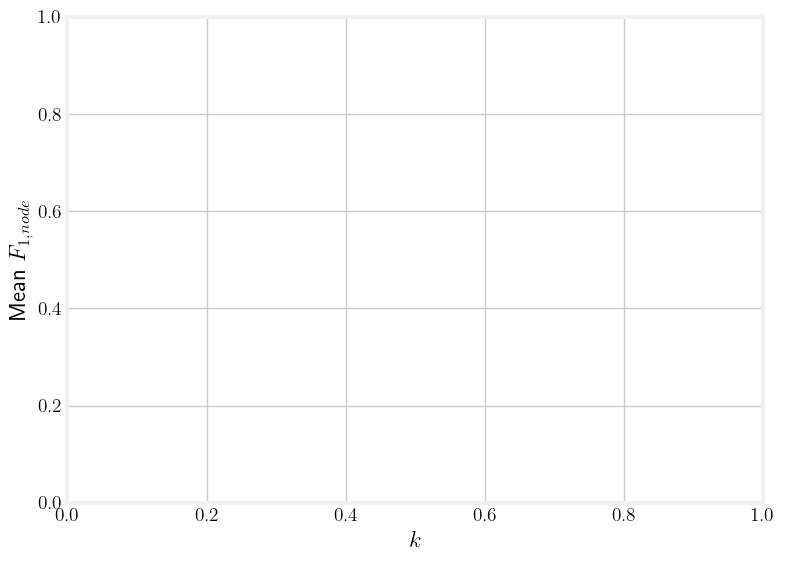

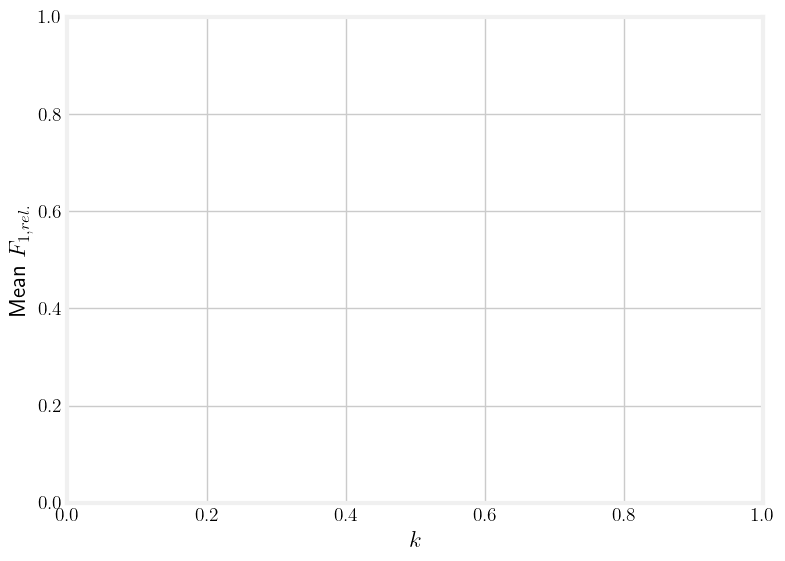

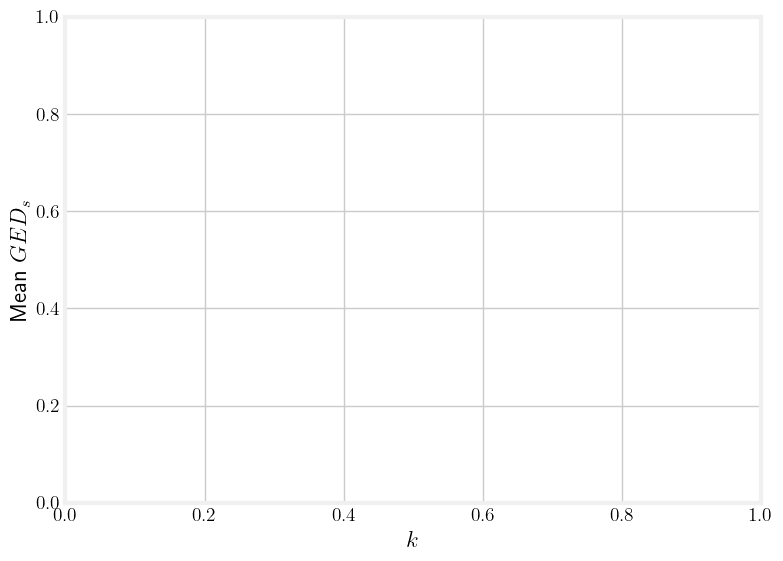

Plotting BTO - f1_score - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - f1_score - raw - Hermes 3 3B
x dashed #a1c9f4


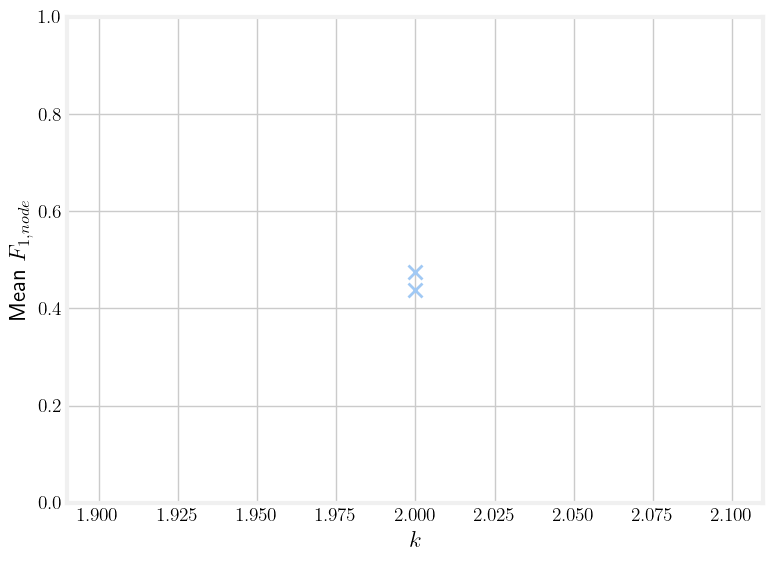

Plotting BTO - f1_score_rel - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - f1_score_rel - raw - Hermes 3 3B
x dashed #a1c9f4


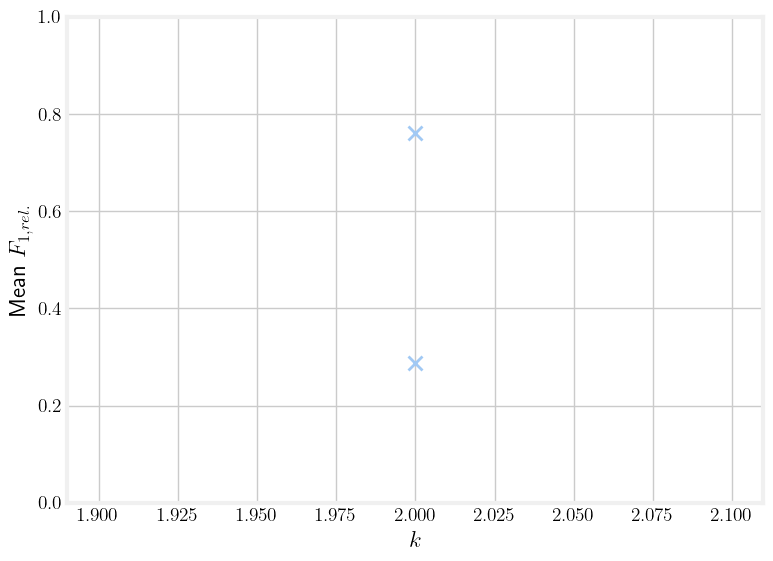

Plotting BTO - normed_ged - aligned - Hermes 3 3B
x solid #a1c9f4
Plotting BTO - normed_ged - raw - Hermes 3 3B
x dashed #a1c9f4


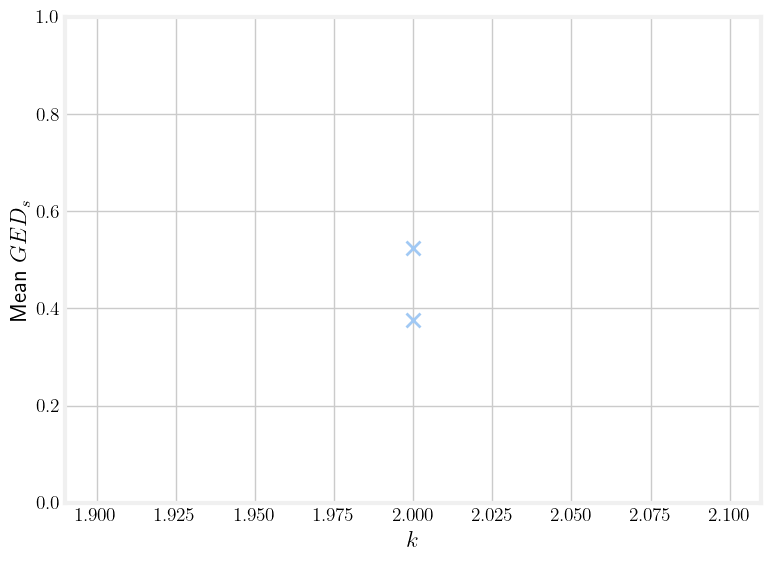

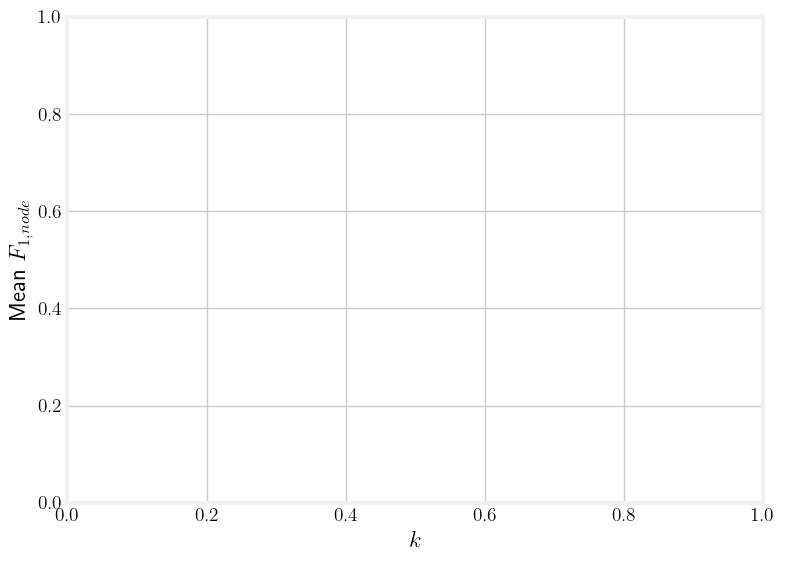

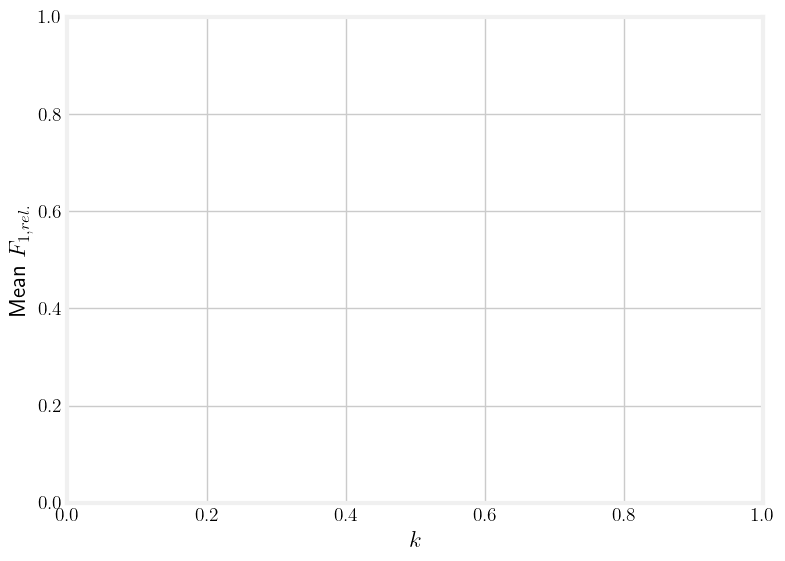

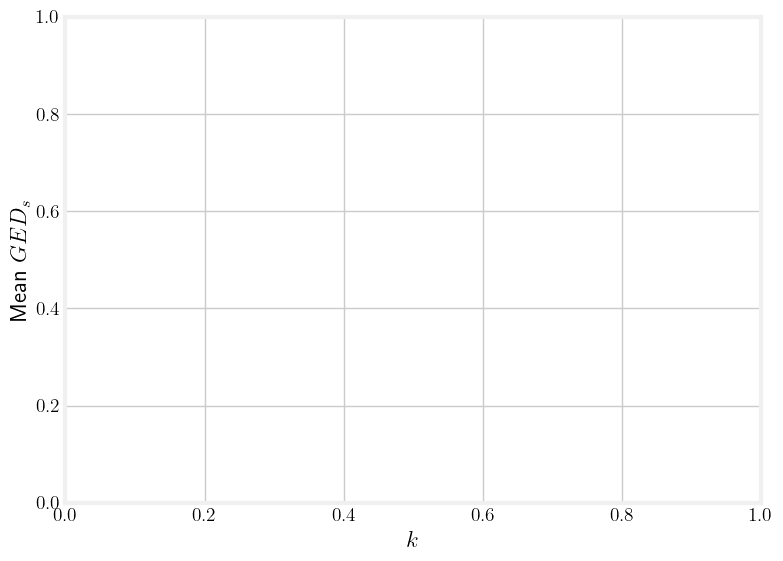

In [37]:
for dataset in grouped_dfs_raw.keys():
    df = grouped_dfs_raw[dataset].reset_index()
    df = df[(df["prompt_type"] == "one shot") & (df["n_nodes"] < 8)]
    metrics = [
        "f1_score",
        "f1_score_rel",
        "normed_ged",
    ]
    for metric in metrics:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        # fig.suptitle(f"{column_map[metric]} for {dataset}")
        patterns_stage = {
            "aligned": "solid",
            "raw": "dashed",
        }
        markers_stage = {
            "aligned": "x",
            "raw": "x",
            }
        for i, model in enumerate(chosen_models):
            for stage in df["stage"].unique():
                data = df[(df["stage"] == stage) & (df["model"] == model)]
                lower, median, upper, mean = tuple(
                    [
                        data[data["percentile"] == q][metric].to_numpy()
                        for q in quantiles + ["mean"]
                    ]
                )
                k = data[data["percentile"] == quantiles[1]]["n_nodes"].to_numpy()
                if not data.empty:
                    # ax.errorbar(
                    #     k,
                    #     median,
                    #     yerr=np.abs(np.stack([lower, upper]) - median),
                    #     label=f"{stage} - {model}",
                    #     marker=markers_stage[stage],
                    #     fillstyle="none",
                    #     markeredgecolor=palette[i],
                    #     # markeredgewidth=10,
                    #     # barsabove=
                    #     capsize=5,
                    #     linestyle=patterns_stage[stage],
                    #     color=palette[i],
                    #     ecolor=adjust_lightness(palette[i]),
                    # )
                    ax.plot(
                        k,
                        mean,
                        label=f"{model} {stage}" if stage == "aligned" else f"{stage}",
                        marker=markers_stage[stage],
                        fillstyle="none",
                        markeredgecolor=palette[i],
                        markersize=10,
                        markeredgewidth=2,
                        linewidth=2,
                        linestyle=patterns_stage[stage],
                        color=palette[i],
                    )
                    print(f"Plotting {dataset} - {metric} - {stage} - {model}")
                    print(markers_stage[stage], patterns_stage[stage], palette[i])

        # ax.set_title(f"Comparison of {dataset} across stages and prompt types")
        ax.set_xlabel("$k$")
        ax.set_ylabel(f"Mean {column_map[metric]}")
        if metric == "f1_score" and dataset == "DBpedia":
            legend=ax.legend(title="Stage - Model")
            legend.set_ncols(2)
        
        ax.set_ylim(0, 1)
        tikzplotlib.save(
            f"figures/compare_{dataset}_{metric}.tex",
            extra_tikzpicture_parameters=[
                "scale=0.5",
                """every axis/.style={
                    legend pos=south west, 
                    legend style={
                font=\\small},
                    legend columns=2, 
                }""",
            ],
            axis_height="1.5\\textwidth",
            axis_width="2\\textwidth",
        )
        plt.show()

In [ ]:
np.stack([lower, upper]).shape

(2, 4)

In [ ]:
upper-lower

array([0.33333333, 0.4       , 0.44444444, 0.42728938])

In [ ]:
(upper - lower) / 2

array([0.16666667, 0.2       , 0.22222222, 0.21364469])